# Audio Detector Model

##### Dataset downloaded from Kaggle: https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist

In [1]:
# Import libraries

import os
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from IPython.display import Audio, display
import librosa.display
plt.rcParams['figure.figsize'] = (10, 4)

import tensorflow as tf
from tensorflow.keras import layers, models

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

### Data Preparation

In [2]:
# Get audio paths and store them in a dataframe
folder_path = os.getcwd() + '/recordings'
speaker_paths = [os.path.join(folder_path, speaker_folder) \
                 for speaker_folder in os.listdir(folder_path) \
                 if not speaker_folder.startswith('.')]

audio_paths = [os.path.join(speaker_path, audio_file) \
               for speaker_path in speaker_paths \
               for audio_file in os.listdir(speaker_path)]

audio_df = pd.DataFrame({'audio_path': audio_paths})
audio_df

,audio_path
0,/Users/chadpark07/Downloads/Deep Learning Proj...
1,/Users/chadpark07/Downloads/Deep Learning Proj...
2,/Users/chadpark07/Downloads/Deep Learning Proj...
3,/Users/chadpark07/Downloads/Deep Learning Proj...
4,/Users/chadpark07/Downloads/Deep Learning Proj...
...,...
29995,/Users/chadpark07/Downloads/Deep Learning Proj...
29996,/Users/chadpark07/Downloads/Deep Learning Proj...
29997,/Users/chadpark07/Downloads/Deep Learning Proj...
29998,/Users/chadpark07/Downloads/Deep Learning Proj...


In [3]:
# Assign speaker and audio label to dataframe

def extract_speaker(path):
    return path.split('/')[-1].split('_')[1]

def extract_labels(path):
    return path.split('/')[-1].split('_')[0]

audio_df['speaker_label'] = audio_df.get('audio_path').apply(extract_speaker)
audio_df['audio_label'] = audio_df.get('audio_path').apply(extract_labels)

audio_df = audio_df.sort_values(by='audio_label')
audio_df

,audio_path,speaker_label,audio_label
14999,/Users/chadpark07/Downloads/Deep Learning Proj...,44,0
13316,/Users/chadpark07/Downloads/Deep Learning Proj...,19,0
13315,/Users/chadpark07/Downloads/Deep Learning Proj...,19,0
13295,/Users/chadpark07/Downloads/Deep Learning Proj...,19,0
13294,/Users/chadpark07/Downloads/Deep Learning Proj...,19,0
...,...,...,...
27438,/Users/chadpark07/Downloads/Deep Learning Proj...,40,9
27440,/Users/chadpark07/Downloads/Deep Learning Proj...,40,9
27441,/Users/chadpark07/Downloads/Deep Learning Proj...,40,9
16611,/Users/chadpark07/Downloads/Deep Learning Proj...,36,9


In [4]:
# Convert spectrogram data into tensors and save dataframe as a csv

def spectrogram_to_tensor(path):
    audio, sr = librosa.load(path)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram /= np.max(spectrogram)
    return tf.convert_to_tensor(spectrogram, dtype=tf.float32)

audio_df.insert(2, 'audio_tensor', audio_df['audio_path'].apply(spectrogram_to_tensor))
audio_df

2024-03-21 14:56:43.639381: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-21 14:56:43.639409: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-21 14:56:43.639420: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-21 14:56:43.639461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-21 14:56:43.639486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


,audio_path,speaker_label,audio_tensor,audio_label
14999,/Users/chadpark07/Downloads/Deep Learning Proj...,44,"((tf.Tensor(0.002986725, shape=(), dtype=float...",0
13316,/Users/chadpark07/Downloads/Deep Learning Proj...,19,"((tf.Tensor(0.00059308397, shape=(), dtype=flo...",0
13315,/Users/chadpark07/Downloads/Deep Learning Proj...,19,"((tf.Tensor(0.00065494457, shape=(), dtype=flo...",0
13295,/Users/chadpark07/Downloads/Deep Learning Proj...,19,"((tf.Tensor(0.00011108527, shape=(), dtype=flo...",0
13294,/Users/chadpark07/Downloads/Deep Learning Proj...,19,"((tf.Tensor(0.00047364825, shape=(), dtype=flo...",0
...,...,...,...,...
27438,/Users/chadpark07/Downloads/Deep Learning Proj...,40,"((tf.Tensor(0.00017688182, shape=(), dtype=flo...",9
27440,/Users/chadpark07/Downloads/Deep Learning Proj...,40,"((tf.Tensor(0.008185564, shape=(), dtype=float...",9
27441,/Users/chadpark07/Downloads/Deep Learning Proj...,40,"((tf.Tensor(0.001039003, shape=(), dtype=float...",9
16611,/Users/chadpark07/Downloads/Deep Learning Proj...,36,"((tf.Tensor(0.00010025931, shape=(), dtype=flo...",9


### Data Exploration

In [5]:
# Display column types

audio_df.dtypes

audio_path       object
speaker_label    object
audio_tensor     object
audio_label      object
dtype: object

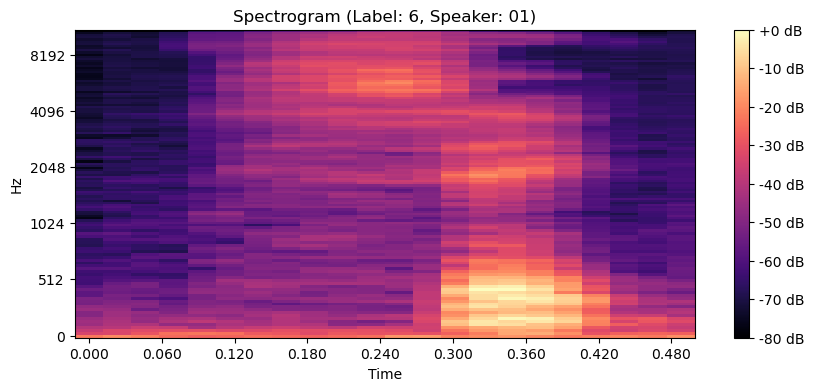

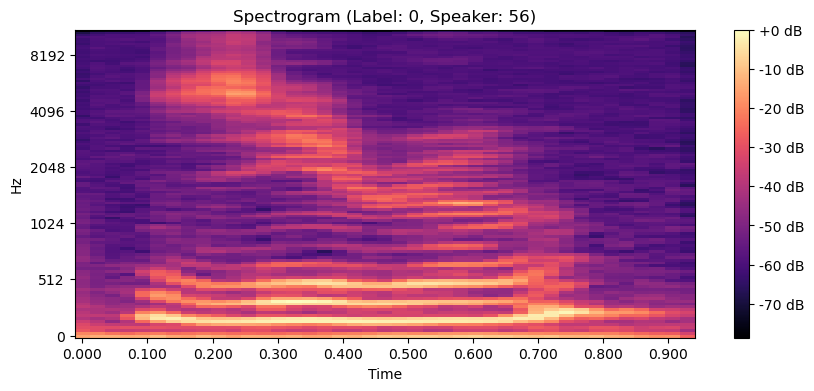

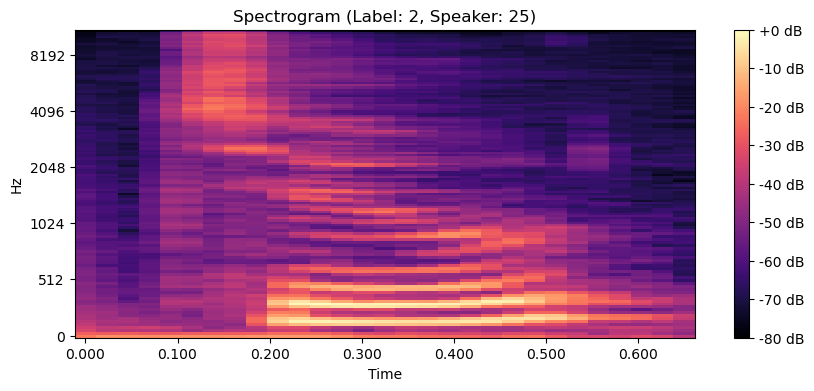

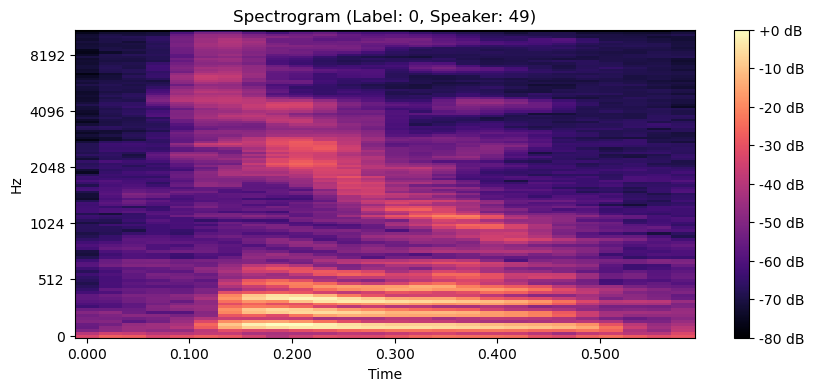

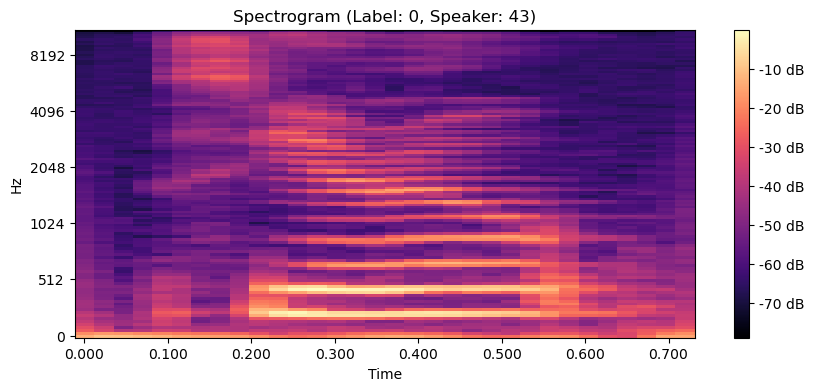

In [6]:
# Display some audio files and their spectrogram

audio_sample = audio_df.sample(5)

for index, row in audio_sample.iterrows():
    display(Audio(row['audio_path']))
    y, sr = librosa.load(row['audio_path'])
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram (Label: ' + row['audio_label'] + ', Speaker: ' + row['speaker_label'] + ')')
    plt.show()

In [7]:
# Display all unique tensor shapes and their counts

shapes = audio_df['audio_tensor'].apply(lambda x: x.shape)
shapes_tuples = shapes.apply(tuple)
unique_shape_counts = shapes_tuples.value_counts()

print('Unique Shapes:')

for shape, count in unique_shape_counts.items():
    print(f'Shape: {shape}, Count: {count}')

Unique Shapes:
Shape: (128, 27), Count: 2469
Shape: (128, 26), Count: 2426
Shape: (128, 25), Count: 2421
Shape: (128, 28), Count: 2291
Shape: (128, 24), Count: 2151
Shape: (128, 29), Count: 2113
Shape: (128, 30), Count: 2041
Shape: (128, 31), Count: 1860
Shape: (128, 23), Count: 1748
Shape: (128, 32), Count: 1541
Shape: (128, 33), Count: 1355
Shape: (128, 22), Count: 1316
Shape: (128, 34), Count: 1138
Shape: (128, 21), Count: 939
Shape: (128, 35), Count: 922
Shape: (128, 36), Count: 684
Shape: (128, 20), Count: 511
Shape: (128, 37), Count: 490
Shape: (128, 38), Count: 353
Shape: (128, 19), Count: 277
Shape: (128, 39), Count: 246
Shape: (128, 40), Count: 185
Shape: (128, 18), Count: 136
Shape: (128, 41), Count: 125
Shape: (128, 43), Count: 87
Shape: (128, 42), Count: 84
Shape: (128, 17), Count: 55
Shape: (128, 16), Count: 23
Shape: (128, 44), Count: 7
Shape: (128, 15), Count: 3
Shape: (128, 14), Count: 2
Shape: (128, 13), Count: 1


In [8]:
# Resize the spectrogram tensors to same shapes

def resize_spectrogram(tensor, target_shape=(128, 32)):
    tensor = tf.expand_dims(tensor, axis=-1)
    padded_tensor = tf.image.resize_with_crop_or_pad(tensor, target_shape[0], target_shape[1])
    return padded_tensor.numpy()

X = audio_df['audio_tensor'].apply(resize_spectrogram)

In [9]:
# Display fixed tensor shapes

fixed_shapes = X.apply(lambda x: x.shape)
fixed_shapes_tuples = fixed_shapes.apply(tuple)
fixed_shape_counts = fixed_shapes_tuples.value_counts()

print('Unique Shapes:')

for shape, count in fixed_shape_counts.items():
    print(f'Shape: {shape}, Count: {count}')

Unique Shapes:
Shape: (128, 32, 1), Count: 30000


### Neural Network Model

In [10]:
# Split the data into training and testing sets

X = np.stack(X)
y = audio_df['audio_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print('Size of dataset:', X.shape)
print('Size of training set:', X_train.shape)
print('Size of testing set:', X_test.shape)

Size of dataset: (30000, 128, 32, 1)
Size of training set: (24000, 128, 32, 1)
Size of testing set: (6000, 128, 32, 1)


In [11]:
# CNN model architecture

def AudioCNN(input_shape):
    model = models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [ ]:
# Create the CNN model

y_train = y_train.astype(np.int32)

input_shape = X_train[0].shape
model = AudioCNN(input_shape)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


In [ ]:
# Evaluate the model

y_test = y_test.astype(np.int32)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
# Display correct and incorrect predictions

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

correct_idxs = np.where(predicted_labels == y_test)[0]
incorrect_idxs = np.where(predicted_labels != y_test)[0]

correct_labels = y_test.iloc[correct_idxs]
print('Correct labels:', len(correct_labels))
print(correct_labels)

incorrect_labels = y_test.iloc[incorrect_idxs]
print('Incorrect labels:', len(incorrect_labels))
print(incorrect_labels)

### Save Model

In [ ]:
# model.save('audio_detector_model')